In [1]:
import os
from os import walk
from os.path import join

import sys
sys.path.append('../')

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from itertools import count
from matplotlib.lines import Line2D
# from keras.models import load_model

from package_Tina.STA import temporalSTA
from package_Tina.PlotResult import plot8by8
from package_Tina.load_data import listfile,readmat_RateAndSti,readmat_SpkAndSti,offsusID
from package_Tina.DataManipulate import downsampling, rescaleData, smooth_conv
from package_Tina.cal_corr import mi_quick, half_corr

Using TensorFlow backend.


### calculate the characteristic of each channel

In [2]:
class CalHMMOU():
    def __init__(self,file):
        self.name = file.split('/')[-1]
        
        signal, rates = readmat_RateAndSti(file)
        self.corr = half_corr(signal)
        nspks = []
        allMI = []
        Pred_Power = []
        MI_Peak = []
        dms = range(-100,101)
        for ch_rate in rates:
            tempMI = [mi_quick(signal,ch_rate,d) for d in dms]
            allMI.append(tempMI)
            Pred_Power.append(sum(tempMI[101:])-sum(tempMI[:100]))
            smoothMI = smooth_conv(np.array(tempMI),window_len=5)
            MI_Peak.append(np.argmax(smoothMI)-100)
        self.MI = allMI
        self.PredPower = Pred_Power
        self.MIpeak = MI_Peak
        self.nspks = sum(rates.T)
        
        channel_data,signalused, TimeStamps, sampling = readmat_SpkAndSti(file)
        allSTA = temporalSTA(channel_data,signalused, TimeStamps, sampling)
        binSTA = downsampling(allSTA)
        self.STA = binSTA
        STA_peak = []
        for sta in binSTA:
            smoothsta = smooth_conv(np.array(sta),window_len=5)
            STA_peak.append(np.argmin(smoothsta)-int(len(smoothsta)/2))
        self.STApeak = STA_peak

### load data and calculate

In [3]:
mypath = '/home/hydroassist/remote_disk/data/Chou/20190408/'
allfile = []
for path, dirs, files in walk(mypath):
    for name in files:
        file= join(path, name)
        if (("HMM" in name.split(".")[0]) or ("OU" in name.split(".")[0])) & (name.split(".")[-1]== 'mat'):
            print(file)
            allfile.append(file)
            signal, rates = readmat_RateAndSti(file)
            print("autocorr=",half_corr(signal),'ms')

expdate = allfile[0].split('/')[-1].split('_')[0]            

/home/hydroassist/remote_disk/data/Chou/20190408/20190408_HMM_G10.mat
autocorr= 330 ms
/home/hydroassist/remote_disk/data/Chou/20190408/20190408_HMM_G2p5.mat
autocorr= 1340 ms
/home/hydroassist/remote_disk/data/Chou/20190408/20190408_HMM_G30.mat
autocorr= 50 ms
/home/hydroassist/remote_disk/data/Chou/20190408/20190408_HMM_G5.mat
autocorr= 690 ms
/home/hydroassist/remote_disk/data/Chou/20190408/20190408_OU_ tau100.mat
autocorr= 50 ms
/home/hydroassist/remote_disk/data/Chou/20190408/20190408_OU_ tau1000.mat
autocorr= 670 ms
/home/hydroassist/remote_disk/data/Chou/20190408/20190408_OU_ tau1800.mat
autocorr= 1310 ms
/home/hydroassist/remote_disk/data/Chou/20190408/20190408_OU_ tau600.mat
autocorr= 340 ms


In [4]:
HMM50 =  CalHMMOU('/home/hydroassist/remote_disk/data/Chou/20190408/20190408_HMM_G30.mat')
OU50 =   CalHMMOU('/home/hydroassist/remote_disk/data/Chou/20190408/20190408_OU_ tau100.mat')
HMM300 = CalHMMOU('/home/hydroassist/remote_disk/data/Chou/20190408/20190408_HMM_G10.mat')
OU300 =  CalHMMOU('/home/hydroassist/remote_disk/data/Chou/20190408/20190408_OU_ tau600.mat')
HMM700 = CalHMMOU('/home/hydroassist/remote_disk/data/Chou/20190408/20190408_HMM_G5.mat')
OU700 =  CalHMMOU('/home/hydroassist/remote_disk/data/Chou/20190408/20190408_OU_ tau1000.mat')


In [5]:
alllegend = ['HMM50','HMM300','HMM700','OU50','OU300','OU700']

In [7]:
import pickle
HMMOUclass = [HMM50,HMM300,HMM700,OU50,OU300,OU700]
pklfile = open(mypath+expdate+'_HMMOUclass.pickle', 'wb')
pickle.dump(HMMOUclass, pklfile)
pklfile.close()

### the electrode of spks smaller than 100

In [8]:
def del_list_numpy(l, id_to_del):
    arr = np.array(l)
    return list(np.delete(arr, id_to_del))

spk_th = 100
muteIDall = [np.where(HMM50.nspks<spk_th)[0],np.where(HMM300.nspks<spk_th)[0],np.where(HMM700.nspks<spk_th)[0],np.where(OU50.nspks<spk_th)[0],np.where(OU300.nspks<spk_th)[0],np.where(OU700.nspks<spk_th)[0]]

from functools import reduce
muteIDunion = reduce(np.union1d, muteIDall)
print(muteIDunion)

[ 1 13 17 18 21 24 25 26 27 35 36 37 56]


### predictive channel

In [9]:
predID = del_list_numpy(np.where(np.array(HMM700.MIpeak)>0)[0],muteIDunion)
print(predID)

[0, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 19, 20, 21, 24, 25, 27, 28, 33, 34, 35, 36, 38, 39, 40, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


/home/hydroassist/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  This is separate from the ipykernel package so we can avoid doing imports until


### output the off-sustain cell

In [10]:
# OffID = offsusID('/home/hydroassist/remote_disk/data/Chou/onoff/20190509_onoff.mat')
OffID =[7,  8, 28, 31, 33, 38, 39, 40, 43, 45, 46, 50, 51, 52, 53, 54, 57, 58, 59]
print(OffID)

[7, 8, 28, 31, 33, 38, 39, 40, 43, 45, 46, 50, 51, 52, 53, 54, 57, 58, 59]


### save figure or display

In [11]:
savefig = False

### compare the STA of HMM and OU 

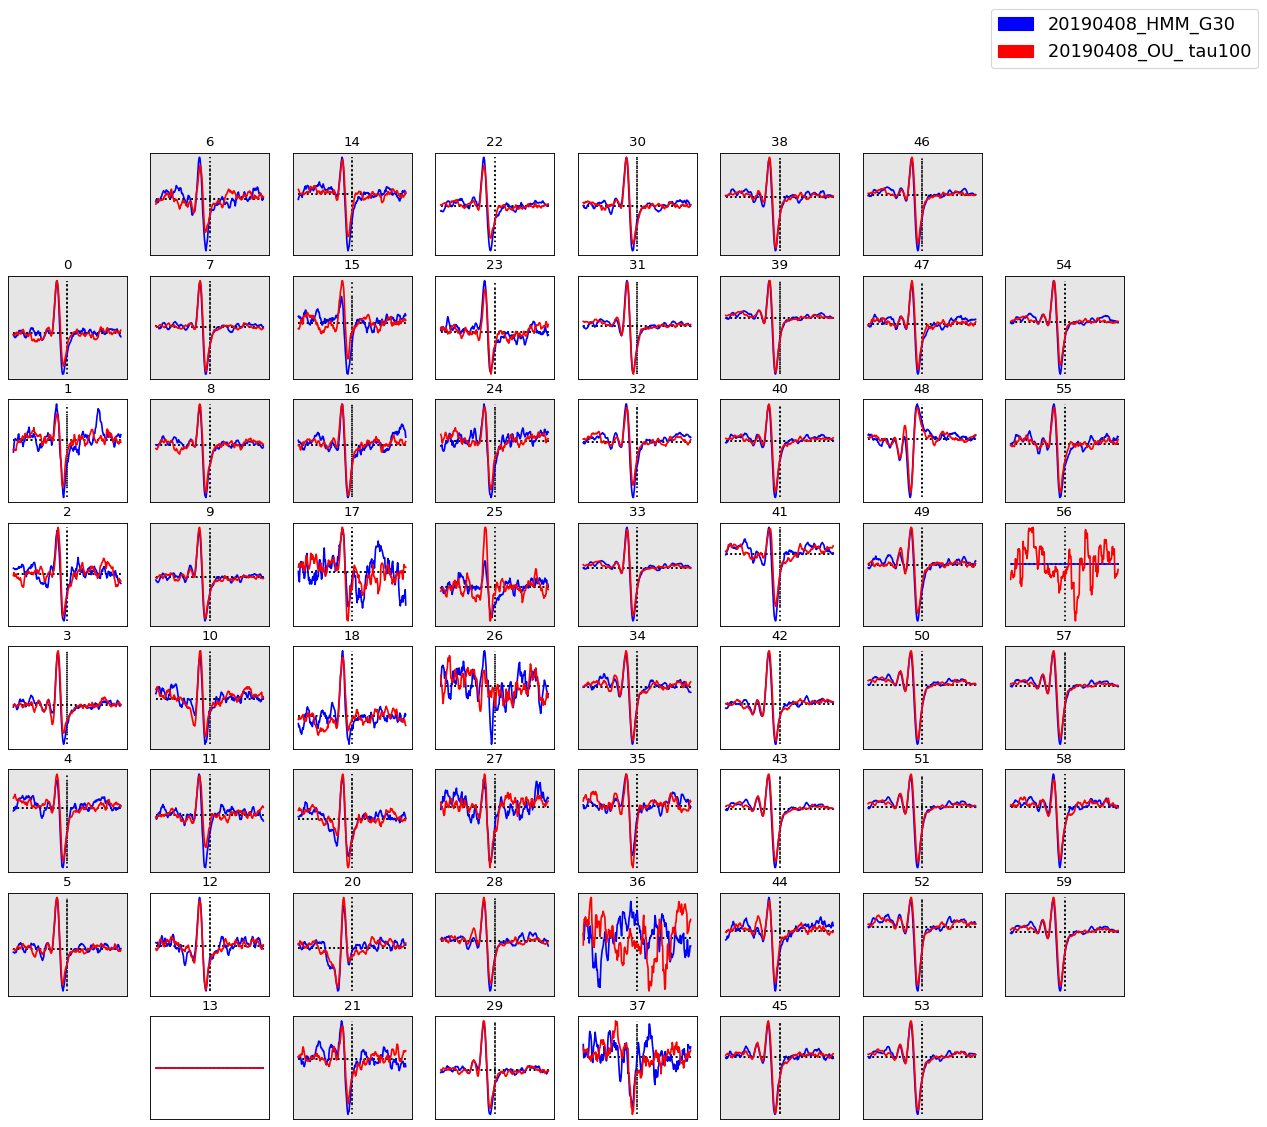

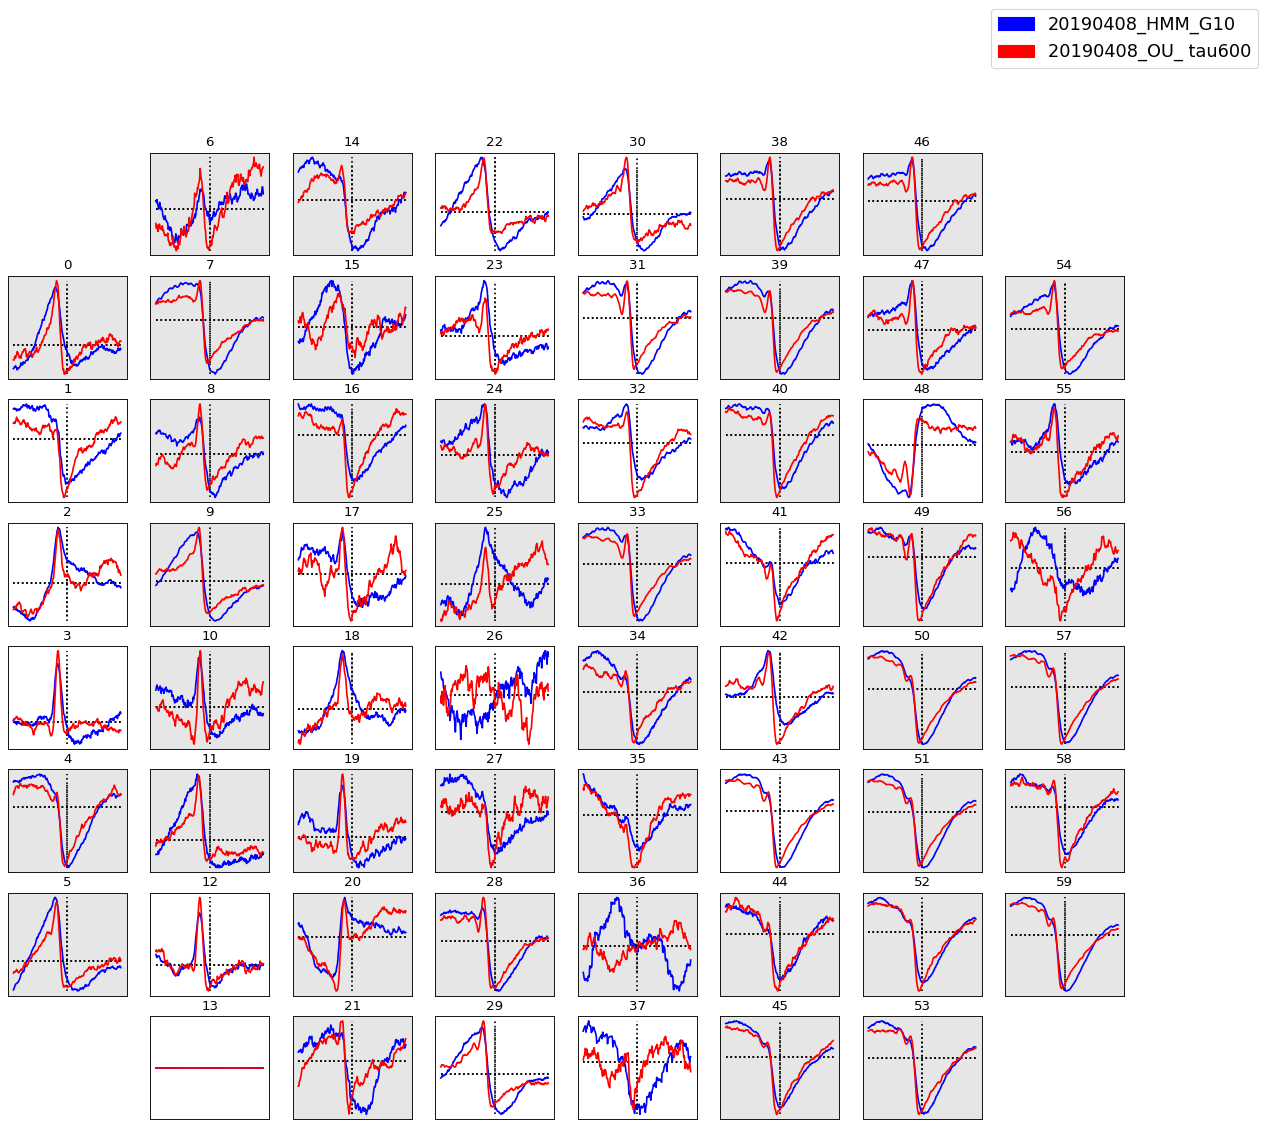

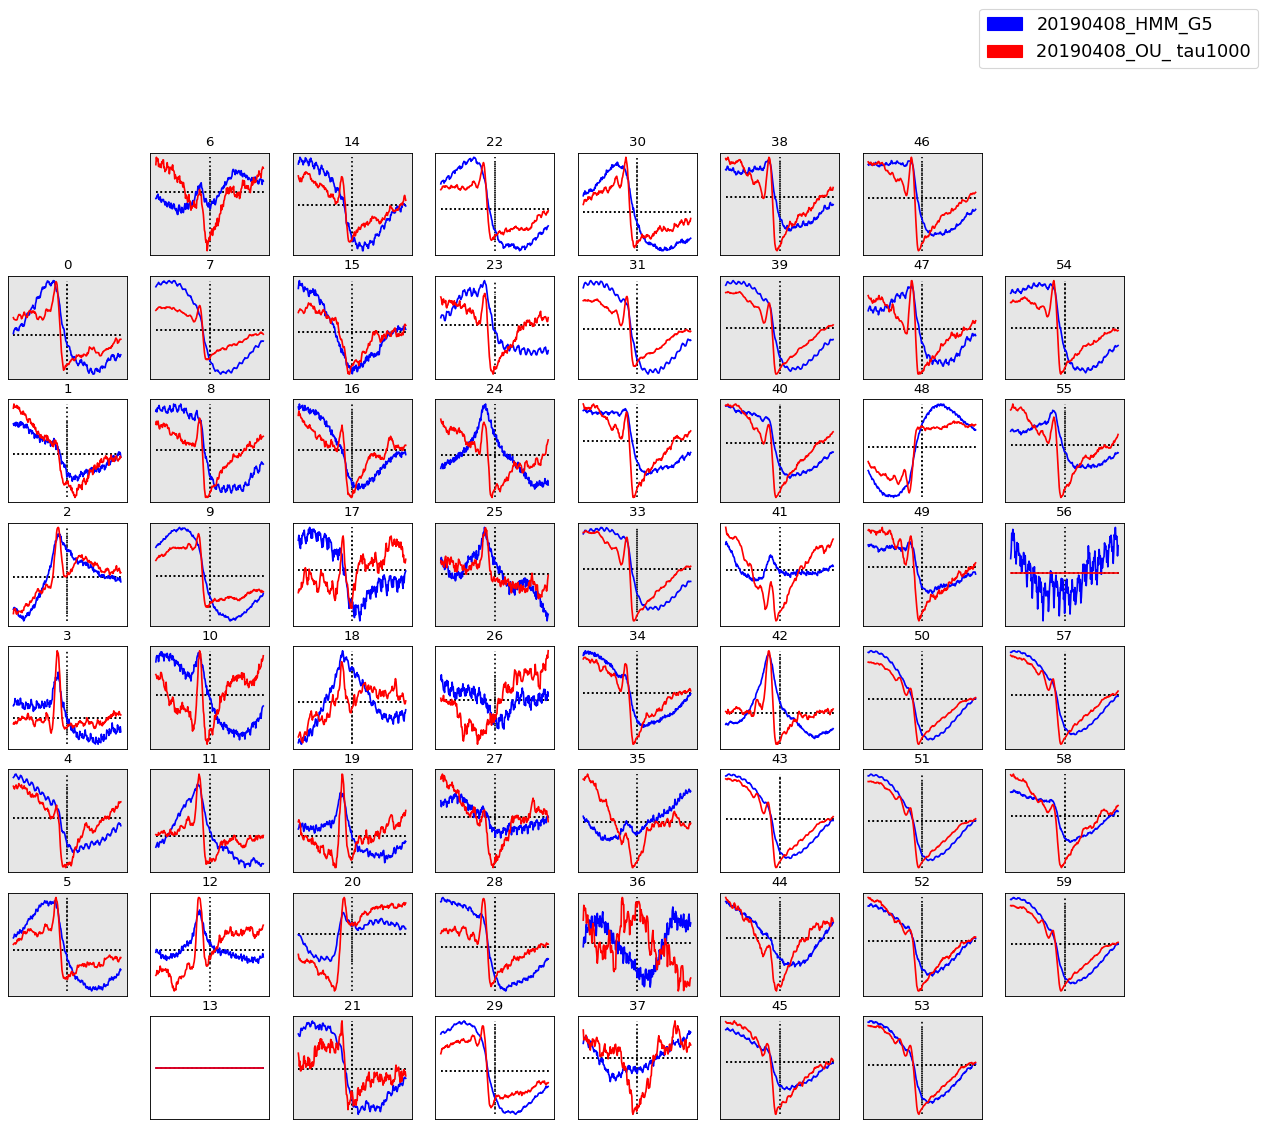

In [12]:
HMMdata = [HMM50,HMM300,HMM700]
OUdata = [OU50,OU300,OU700]
filenamedata = [expdate+"HMMOU50.jpg", expdate+"HMMOU300.jpg",expdate+"HMMOU700.jpg"]
for file1,file2,filename in zip(HMMdata,OUdata,filenamedata):
    figdata = [file1.STA, file2.STA]
    fidledg = [file1.name[:-4],file2.name[:-4]]
    plot8by8(figdata, fidledg ,imgsave=savefig,bgcolorID=predID,hlineloc=1,filename=join(mypath, filename))

### compare the MI of HMM or OU 

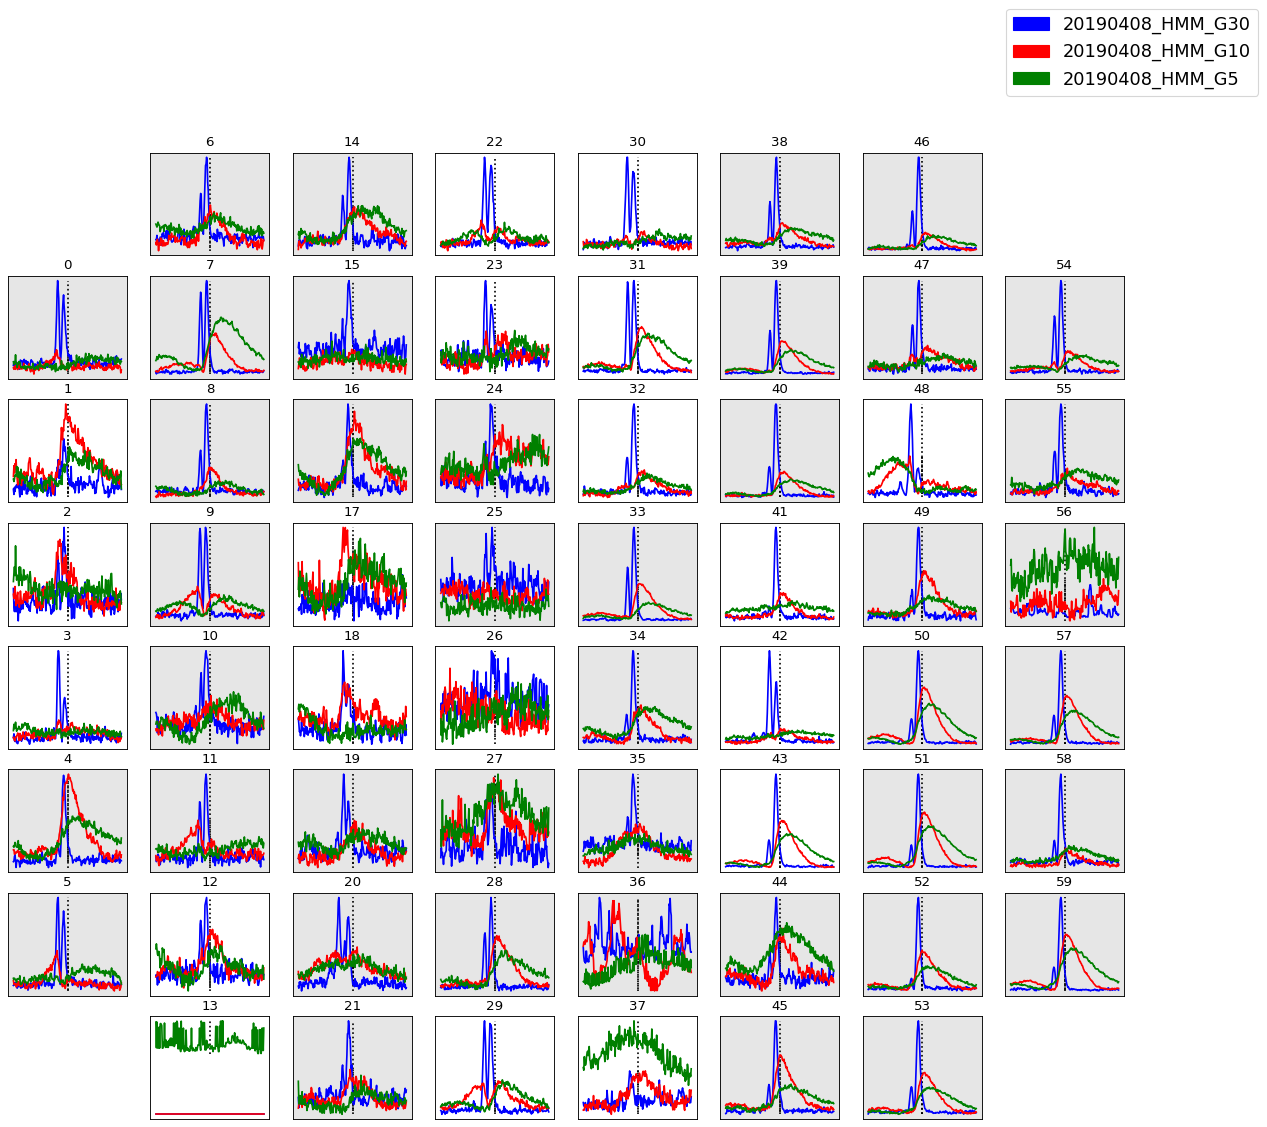

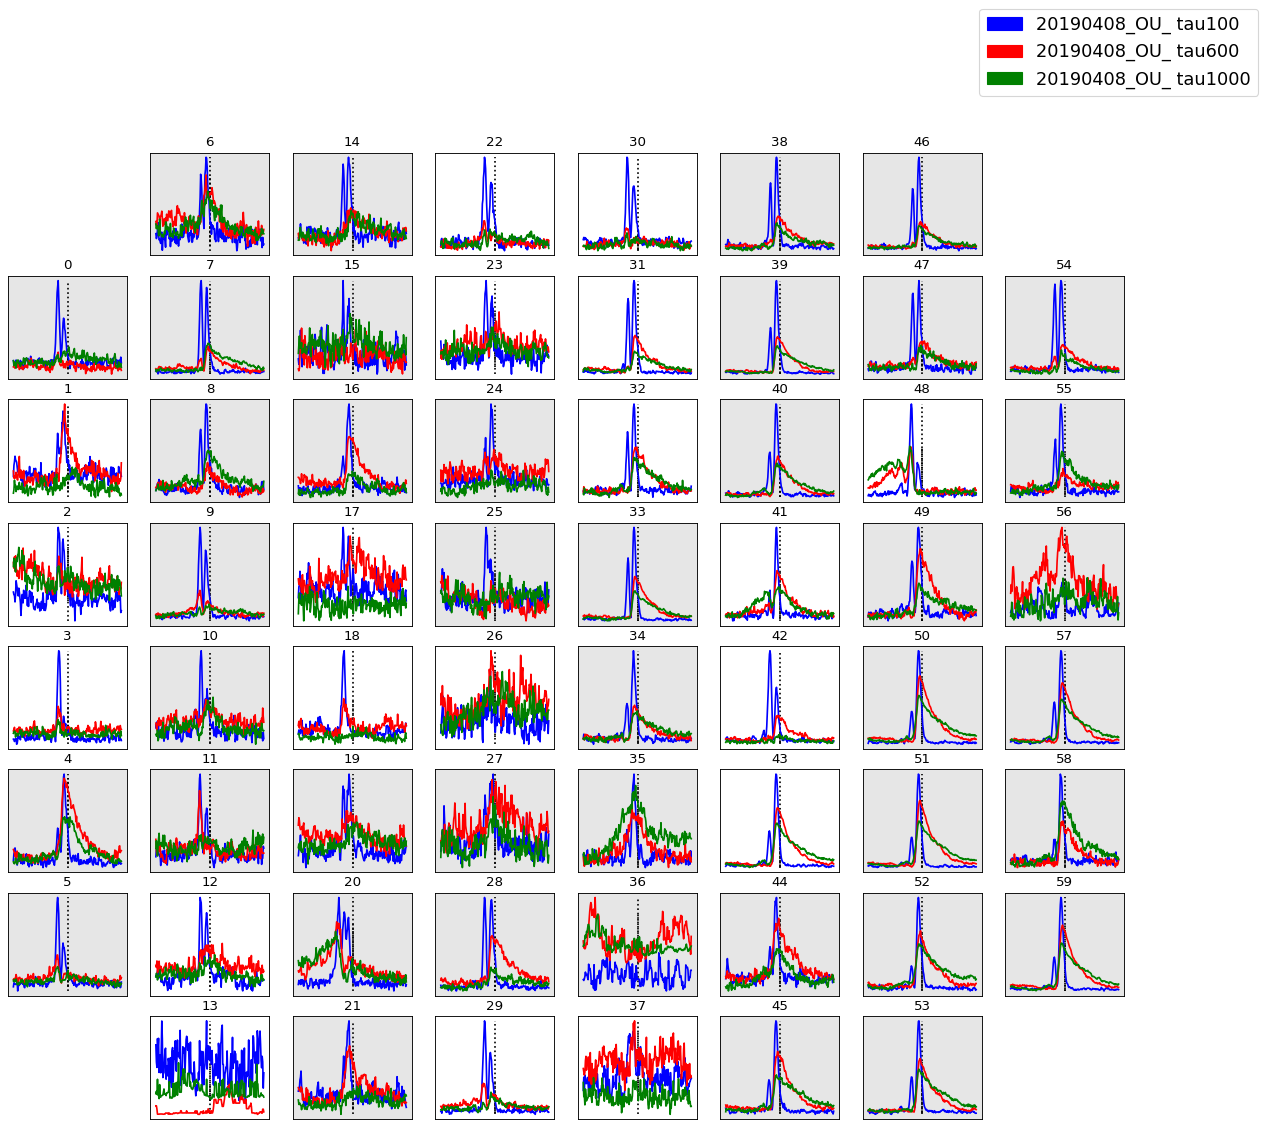

In [13]:
file1all=[HMM50,OU50]
file2all=[HMM300,OU300]
file3all=[HMM700,OU700]
filenameall = [expdate+"HMM_MI.jpg",expdate+"OU_MI.jpg"]

dms = range(-100,101)
for file1, file2, file3, filename in zip(file1all, file2all, file3all, filenameall):
    figdata =[file1.MI, file2.MI,file3.MI]
    fidledg =[file1.name[:-4],file2.name[:-4],file3.name[:-4]]
    plot8by8(figdata, fidledg,bgcolorID=predID, filename=join(mypath, filename))

### plot the predictive power

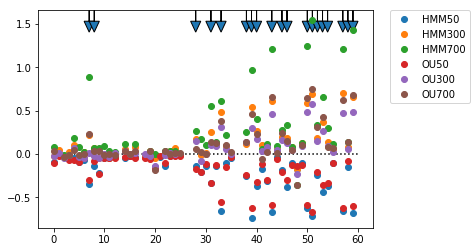

In [14]:
DataIn = [HMM50.PredPower,HMM300.PredPower,HMM700.PredPower,OU50.PredPower,OU300.PredPower,OU700.PredPower]
alllegend = ['HMM50','HMM300','HMM700','OU50','OU300','OU700']
for data,muteID in zip(DataIn,muteIDall):
    plt.plot(del_list_numpy(list(range(60)),muteID),del_list_numpy(data,muteID),'o')
Yrange = plt.gca().get_ylim()
ylimscl = Yrange[1]-Yrange[0]
for ID in OffID:
    plt.arrow(ID,Yrange[1],0,-ylimscl*0.05,head_width=2, head_length=ylimscl*0.05)
plt.legend(alllegend,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(0,0,60,linestyles='dotted')
if savefig == True:
    plt.savefig(join(mypath, filename)[:-4] + '_PredPower' +'.png', bbox_inches='tight')#,transparent=True
    plt.clf()
    plt.close()
else :
    plt.show()

### plot the MI peak

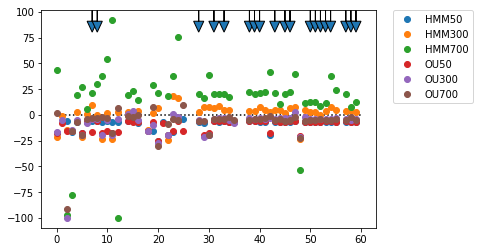

In [15]:
DataIn = [HMM50.MIpeak ,HMM300.MIpeak ,HMM700.MIpeak ,OU50.MIpeak ,OU300.MIpeak ,OU700.MIpeak ]
alllegend = ['HMM50','HMM300','HMM700','OU50','OU300','OU700']
for data,muteID in zip(DataIn,muteIDall):
    plt.plot(del_list_numpy(list(range(60)),muteID),del_list_numpy(data,muteID),'o')
Yrange = plt.gca().get_ylim()
ylimscl = Yrange[1]-Yrange[0]
for ID in OffID:
    plt.arrow(ID,Yrange[1],0,-ylimscl*0.05,head_width=2, head_length=ylimscl*0.05)
plt.legend(alllegend,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.hlines(0,0,60,linestyles='dotted')
if savefig == True:
    plt.savefig(join(mypath, filename)[:-4] + '_MIpeak' +'.png', bbox_inches='tight')#,transparent=True
    plt.clf()
    plt.close()
else :
    plt.show()

### relation of MI peak and STA

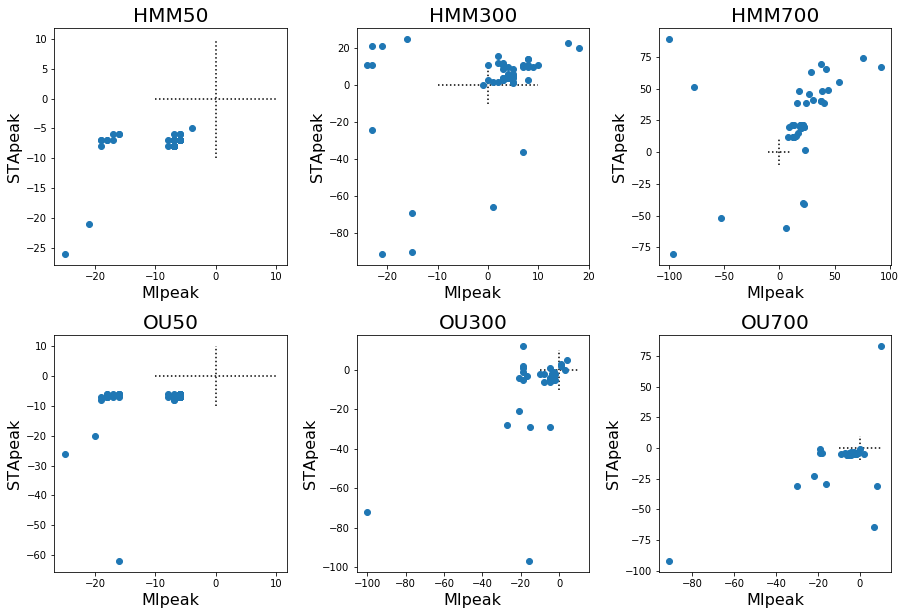

In [16]:
MIpeakIn = [HMM50.MIpeak ,HMM300.MIpeak ,HMM700.MIpeak ,OU50.MIpeak ,OU300.MIpeak ,OU700.MIpeak ]
STApeakIn = [HMM50.STApeak ,HMM300.STApeak ,HMM700.STApeak ,OU50.STApeak ,OU300.STApeak ,OU700.STApeak ]
alllegend = ['HMM50','HMM300','HMM700','OU50','OU300','OU700']
plt.figure(figsize=(15,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
for count,(MIpeak,STApeak,muteID) in enumerate(zip(MIpeakIn,STApeakIn,muteIDall)):
    plt.subplot(2,3,count+1)
    plt.title(alllegend[count],fontsize='20')
    plt.plot(del_list_numpy(MIpeak,muteID),del_list_numpy(STApeak,muteID),'o')
    plt.hlines(0,-10,10,linestyles='dotted')
    plt.vlines(0,-10,10,linestyles='dotted')
    plt.xlabel('MIpeak',fontsize='16')
    plt.ylabel('STApeak',fontsize='16')    
plt.show()
    

In [17]:
MIpeakIn = [HMM50.MIpeak ,HMM300.MIpeak ,HMM700.MIpeak ,OU50.MIpeak ,OU300.MIpeak ,OU700.MIpeak]
STAIn = [HMM50.STA ,HMM300.STA ,HMM700.STA ,OU50.STA ,OU300.STA ,OU700.STA]


### Compare STA and N/P type

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 19, 20, 22, 23, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59]
[]
[0, 2, 3, 5, 9, 11, 48, 22]
[4, 6, 7, 10, 12, 14, 15, 16, 19, 20, 23, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 53, 54, 55, 57, 58, 59]
[48, 2, 3, 12]
[0, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 19, 20, 22, 23, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 19, 20, 22, 23, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59]
[]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 19, 20, 22, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59]
[23, 47, 14, 15]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 20, 22, 23, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 41, 4

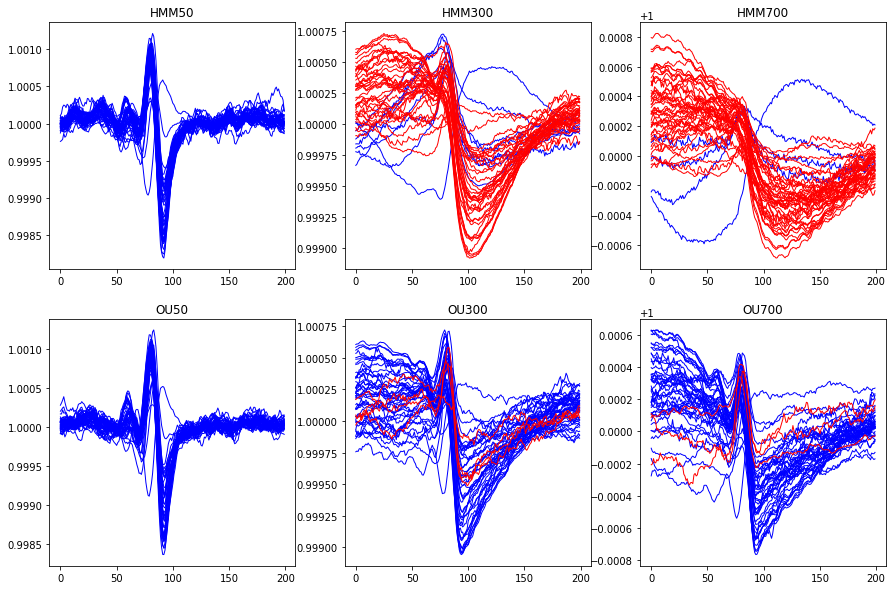

In [18]:
plt.figure(figsize=[15,10])
for count, (mipeak,sta,nameid) in enumerate(zip(MIpeakIn,STAIn,alllegend)):
    delayID = list(set(np.where(np.array(mipeak)<0)[0]) - set(muteIDunion))
    print(delayID)
    predID = list(set(np.where(np.array(mipeak)>0)[0]) - set(muteIDunion))
    print(predID)
    plt.subplot(2,3 ,count+1)
    for i in delayID :
        plt.plot(sta[i], color='b', lw=1)
    for j in predID : 
        plt.plot(sta[j], color='r', lw=1)

    plt.title(nameid)
plt.show()